In [1]:
import numpy as np
import os
import sys
import torch
import torch.nn as nn
import gc
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import torch

In [2]:
sys.path.append(os.path.dirname(os.getcwd()))
print(os.getcwd())
from EDP_Model_Testing.test_lstm import WindTurbineDataset, get_data_loaders, get_aggregate_data, get_data_loaders_by_timestamp, MaskedLSTM, inference

/sfs/gpfs/tardis/home/ujx4ab/ondemand/dissecting_dist_inf/WF_Data/EDP/EDP_Model_Testing


In [3]:
def plot_anomalies(timestamps, anomalies, df_name="Dataset",start_time = None, end_time=None):
    datetime_index = pd.DatetimeIndex(timestamps)
    if start_time is None and end_time is None: 
        start_time=datetime_index.min()
        end_time=datetime_index.max(),
    complete_range = pd.date_range(start=start_time, end=end_time, freq='10min')
    missing_timestamps = sorted(set(complete_range) - set(timestamps))

    if not isinstance(anomalies, torch.Tensor):
        anomalies = torch.tensor(anomalies)

    anomaly_indices = torch.where(anomalies == True)[0]  # Get the indices
    anomaly_timestamps = [timestamps[i] for i in anomaly_indices.tolist()]  # Use list comprehension to extract the timestamps

    print("Total expected timestamps:", len(complete_range))
    print("Total normal timestamps:", torch.sum(anomalies == False).item())  # Fix: Ensuring it's a tensor
    print("Total anomalous timestamps:", torch.sum(anomalies == True).item())  # Fix: Ensuring it's a tensor
    print("Total missing timestamps:", len(missing_timestamps))

    # Plot the timeline with missing timestamps and anomalies
    plt.figure(figsize=(15, 6))

    # Plot expected timestamps
    plt.plot(complete_range, [1] * len(complete_range), '|', color='blue', markersize=10, label='Expected Timestamps')

    # Plot missing timestamps
    if missing_timestamps:
        plt.plot(missing_timestamps, [1] * len(missing_timestamps), '|', color='red', markersize=10, label='Missing Timestamps')

    # Plot anomalies
    if len(anomaly_timestamps) > 0:
        plt.plot(anomaly_timestamps, [1] * len(anomaly_timestamps), '|', color='orange', markersize=10, label='Anomalies')

    # Formatting
    plt.xlabel('Timestamp')
    plt.ylabel('Presence Indicator')
    plt.title(f'{df_name} Missing & Anomalous Timestamps (10-Minute Intervals)')
    plt.legend()
    plt.show()

/home/ujx4ab/ondemand/dissecting_dist_inf/.venv/lib64/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Running Inference of validation loader: 100%|██████████| 347/347 [00:17<00:00, 19.81batch/s]


Threshold: 0.16728441238403313


Running Inference of test loader: 100%|██████████| 957/957 [00:32<00:00, 29.48batch/s]


Final Test MSE: 0.0041


Running Inference of validation loader: 100%|██████████| 347/347 [00:11<00:00, 30.00batch/s]


Threshold: 0.11120486021041857


Running Inference of test loader: 100%|██████████| 957/957 [00:32<00:00, 29.66batch/s]


Final Test MSE: 0.0010
Total expected timestamps: 105261
Total normal timestamps: 30129
Total anomalous timestamps: 466
Total missing timestamps: 74666


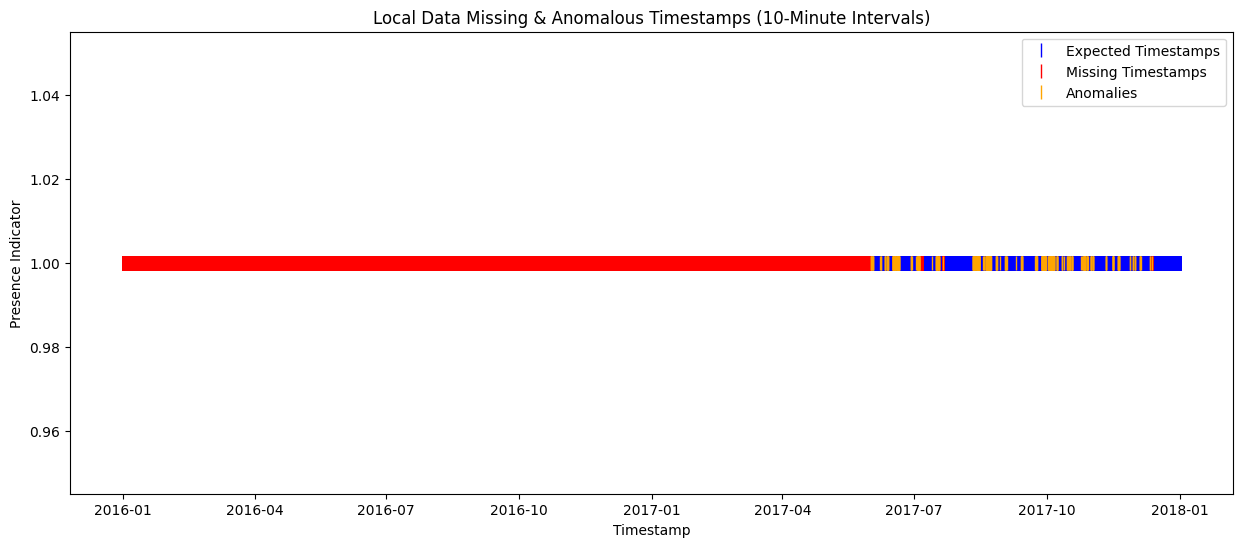

Total expected timestamps: 105261
Total normal timestamps: 30318
Total anomalous timestamps: 277
Total missing timestamps: 74666


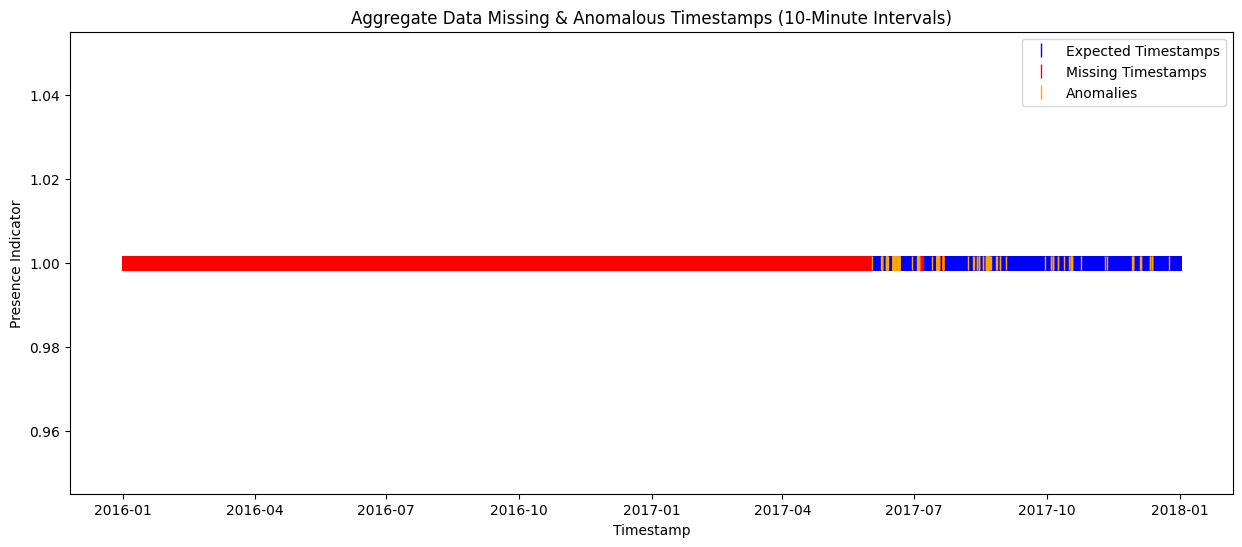

In [5]:
MODEL_FOLDER = "/home/ujx4ab/ondemand/dissecting_dist_inf/WF_Data/EDP/EDP_Model_Testing/models"
DATA_FOLDER = "/home/ujx4ab/ondemand/dissecting_dist_inf/WF_Data/EDP/EDP_Model_Testing/data_prep_faults_included"

INPUT_SIZE = 22
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
BATCH_SIZE = 32
NUM_EPOCHS = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOSS_FN = nn.MSELoss()

WTs = ["01"] #, "06", "07", "11"]

test_loaders = dict()
val_loaders = dict()

for WT in WTs: 
    test_dataset = WindTurbineDataset(
        X_path=f"{DATA_FOLDER}/EDP_WT_{WT}_X.pt",
        y_path=f"{DATA_FOLDER}/EDP_WT_{WT}_y.pt",
        timestamps_path=f"{DATA_FOLDER}/EDP_WT_{WT}_timestamp.pkl"
    )
    train_loader, val_loader, test_loader = get_data_loaders_by_timestamp(test_dataset, split_timestamp="2017-06-01")
    
    test_loaders[WT] = test_loader
    val_loaders[WT] = val_loaders

for WT in WTs: 
    local_WT = WT

    CKPT_local = f"/home/ujx4ab/ondemand/dissecting_dist_inf/WF_Data/EDP/EDP_Model_Testing/models/simple_lstm_WT_{local_WT}.pth"
    local_model = MaskedLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, use_dropout=False).to(DEVICE)

    CKPT_aggregate = f"/home/ujx4ab/ondemand/dissecting_dist_inf/WF_Data/EDP/EDP_Model_Testing/models/simple_lstm_WT_aggregate.pth"
    aggregate_model = MaskedLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, use_dropout=False).to(DEVICE)

    test_dataset = WindTurbineDataset(
        X_path=f"{DATA_FOLDER}/EDP_WT_{local_WT}_X.pt",
        y_path=f"{DATA_FOLDER}/EDP_WT_{local_WT}_y.pt",
        timestamps_path=f"{DATA_FOLDER}/EDP_WT_{local_WT}_timestamp.pkl"
    )

    def load_and_evaluate_model(model, ckpt_path, test_loader, val_loader):
        """Loads a model, evaluates on validation, and runs inference on test data."""
        checkpoint = torch.load(ckpt_path, weights_only=True)
        model.load_state_dict(checkpoint)
        model.eval()

        val_preds, val_true, _, _ = inference(model, val_loader, DEVICE, threshold=None, data_loader_name="validation loader")
        threshold = np.quantile(val_preds - val_true, 0.99)
        print(f"Threshold: {threshold}")

        preds, true, anomalies, timestamps = inference(model, test_loader, DEVICE, threshold=threshold, data_loader_name="test loader")
        mse = LOSS_FN(preds, true)
        print(f"Final Test MSE: {mse.item():.4f}")

        return preds, true, anomalies, timestamps

    local_model = MaskedLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, use_dropout=False).to(DEVICE)
    local_preds, local_true, local_anomalies, local_timestamps = load_and_evaluate_model(local_model, CKPT_local, test_loader, val_loader)

    del local_model
    torch.cuda.empty_cache()
    gc.collect()

    aggregate_model = MaskedLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, use_dropout=False).to(DEVICE)
    preds, true, anomalies, timestamps = load_and_evaluate_model(aggregate_model, CKPT_aggregate, test_loader, val_loader)

    del aggregate_model
    torch.cuda.empty_cache()
    gc.collect()

    datetimes = [datetime.datetime.utcfromtimestamp(ts.item()) for ts in timestamps]
    plot_anomalies(datetimes, local_anomalies, df_name="Local Data",  start_time="2016-01-01 00:00:00", end_time="2017-12-31 23:20:00")
    plot_anomalies(datetimes, anomalies, df_name="Aggregate Data",  start_time="2016-01-01 00:00:00", end_time="2017-12-31 23:20:00")
